In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from flygym import Fly, Camera, SingleFlySimulation
from flygym.util import get_data_path

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
# Initialize the simulation
adhesion = True
run_time = 1

fly = Fly(
    spawn_pos=(0, 0, 0.2),
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right",
    play_speed=0.05,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

num_steps_base = int(run_time / sim.timestep)

In [4]:
# Load recorded data
data_path = get_data_path("flygym", "data")

with open(data_path / "behavior" / "single_steps_untethered.pkl", "rb") as f:
    data = pickle.load(f)

In [5]:
data["swing_stance_time"]

{'swing': {'RF': 0.0, 'RM': 0.0, 'RH': 0.0, 'LF': 0.0, 'LM': 0.0, 'LH': 0.0},
 'stance': {'RF': 0.051000000000000004,
  'RM': 0.048,
  'RH': 0.042,
  'LF': 0.051000000000000004,
  'LM': 0.048,
  'LH': 0.042}}

In [6]:
# Interpolate 5x
step_duration = len(data["joint_LFCoxa"])
interp_step_duration = int(step_duration * data["meta"]["timestep"] / sim.timestep)
data_block = np.zeros((len(fly.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data["meta"]["timestep"]
interp_t = np.arange(interp_step_duration) * sim.timestep
for i, joint in enumerate(fly.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [7]:
n_stabilization_step = 2000

sim.reset()

legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
match_joints_to_leg = np.array(
    [[i for i, joint in enumerate(fly.actuated_joints) if leg in joint] for leg in legs]
)
obs_list = []

for i, l in enumerate(legs):
    if i == 0:
        for j in range(n_stabilization_step):
            joint_angles = data_block[:, 0]
            action = {"joints": joint_angles, "adhesion": np.zeros(6)}
            obs_list.append(sim.step(action)[0])
            render_status = sim.render()

    for j in range(interp_step_duration):
        joint_angles = data_block[:, 0]
        joint_angles[match_joints_to_leg[i]] = data_block[match_joints_to_leg[i], j]
        action = {"joints": joint_angles, "adhesion": np.zeros(6)}
        obs_list.append(sim.step(action)[0])
        render_status = sim.render()

In [8]:
video_path = Path(f"outputs/single_step.mp4")
cam.save_video(video_path, stabilization_time=0.15)

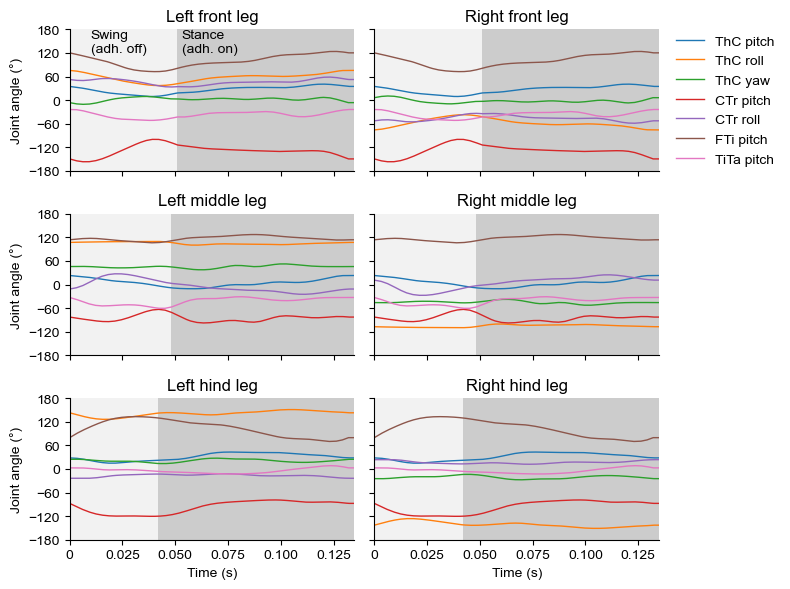

In [9]:
side_lookup = {"L": "left", "R": "right"}
pos_lookup = {"F": "front", "M": "middle", "H": "hind"}
joint_lookup = {
    "Coxa": "ThC pitch",
    "Coxa_roll": "ThC roll",
    "Coxa_yaw": "ThC yaw",
    "Femur": "CTr pitch",
    "Femur_roll": "CTr roll",
    "Tibia": "FTi pitch",
    "Tarsus1": "TiTa pitch",
}

fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), tight_layout=True, sharex=True, sharey=True
)
for i, (pos_code, pos) in enumerate(pos_lookup.items()):
    for j, (side_code, side) in enumerate(side_lookup.items()):
        ax = axs[i, j]
        for joint_code, joint_name in joint_lookup.items():
            idx = fly.actuated_joints.index(f"joint_{side_code}{pos_code}{joint_code}")
            ax.plot(
                interp_t, np.rad2deg(data_block[idx, :]), label=joint_name, linewidth=1
            )

        # plot adhesion on/off
        swing_start = data["swing_stance_time"]["swing"][f"{side_code}{pos_code}"]
        stance_start = data["swing_stance_time"]["stance"][f"{side_code}{pos_code}"]
        ax.fill_between(
            [0, swing_start],
            [-180, -180],
            [180, 180],
            facecolor="gray",
            edgecolor="none",
            alpha=0.4,
            linewidth=1,
        )
        ax.fill_between(
            [swing_start, stance_start],
            [-180, -180],
            [180, 180],
            facecolor="gray",
            edgecolor="none",
            alpha=0.1,
            linewidth=1,
        )
        ax.fill_between(
            [stance_start, interp_t[-1]],
            [-180, -180],
            [180, 180],
            facecolor="gray",
            edgecolor="none",
            alpha=0.4,
            linewidth=1,
        )

        ax.set_title(f"{side.title()} {pos} leg")
        ax.set_ylim(-180, 180)
        ax.set_xlim(0, interp_t[-1])
        ax.set_yticks([-180, -120, -60, 0, 60, 120, 180])

        xticks = [0, 0.025, 0.05, 0.075, 0.100, 0.125]
        xticklabels = [0, "0.025", "0.050", "0.075", "0.100", "0.125"]
        ax.set_xticks(xticks, labels=xticklabels)

        if i == 0 and j == 1:
            ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        if i == 2:
            ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Joint angle (°)")

        if i == 0 and j == 0:
            ax.text(
                swing_start + 0.01,
                1,
                "Swing\n(adh. off)",
                transform=ax.get_xaxis_transform(),
                va="top",
            )

            ax.text(
                stance_start + 0.002,
                1,
                "Stance\n(adh. on)",
                transform=ax.get_xaxis_transform(),
                va="top",
            )

sns.despine()

leg = axs[0, 1].get_legend()
leg.get_frame().set_linewidth(0.0)

fig.savefig("outputs/single_step.pdf", bbox_inches="tight")

In [10]:
import pandas as pd

df = {"leg": [], "joint": [], "time": [], "angle_deg": []}

for i, (pos_code, pos) in enumerate(pos_lookup.items()):
    for j, (side_code, side) in enumerate(side_lookup.items()):
        for joint_code, joint_name in joint_lookup.items():
            df["leg"].extend([f"{side}_{pos}"] * len(interp_t))
            df["joint"].extend([joint_code.lower()] * len(interp_t))
            df["time"].extend(interp_t)
            df["angle_deg"].extend(np.rad2deg(data_block[i, :]))

df = pd.DataFrame(df)
df.to_csv("outputs/single_step.csv", index=False)